### Test conversion script used by importasdm

In [2]:
#from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
#from casatools import measures, quanta, table, image, msmetadata
import os
#from astropy.io import fits
#from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
#msmd = msmetadata()
from casatools import measures, table, quanta
from casatasks.private import convertephem as conveph
from casatasks.private import jplhorizons_query as jplh
me = measures()
qa = quanta()
tb = table()
import numpy as np

In [3]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
from ipynb.fs.defs.EphemerisObjectImagingDemoFunctions import *

### ephmeris data for Venus (assuming observed at ALMA)

In [4]:
# A query was made via JPL-Horizons web interface interactively with the same time range and time interval
# (shown below) as one attached in venus_ephem_test.ms and the raw result was saved to horizons_result.txt
# time range : 2019/01/08/09:20:00 ~ 2019/01/08/18:00:00
# interval : 20 min
# observer location : ALMA

#### Following step requres CAS-14408 build

In [5]:
jplh.tocasatb('horizons_results.txt', 'Venus_ALMA_20190108.tab')

In [6]:
def compare_ephemtable(tab1, tab2):
    """
    Compare two ephemeris tables  
    """
    if os.path.exists(tab1):
        tb.open(tab1)
        mjd1 = tb.getcol('MJD')
        ra1 = tb.getcol('RA')
        dec1 = tb.getcol('DEC')
        tb.done()
    else:
        raise RuntimeError(f'{tab1} does not exist')
    if os.path.exists(tab2):
        tb.open(tab2)
        mjd2 = tb.getcol('MJD')
        ra2 = tb.getcol('RA')
        dec2 = tb.getcol('DEC')
        tb.done()
    else:
        raise RuntimeError(f'{tab2} does not exist')

    tab1name = os.path.basename(tab1.rstrip('/'))
    tab2name = os.path.basename(tab2.rstrip('/'))
# plotting
    fig, (ax0,ax1)  = pl.subplots(2,1)
    fig.suptitle(f'{tab2name} - {tab2name} (uncorrected) posisition comparison')
    ax0.scatter(mjd1,ra1, s=10, label=tab1name)
    ax0.scatter(mjd2,ra2, s=10, label=tab2name)
    ax0.set_ylabel('RA [deg]')
    ax0.legend()
    ax1.scatter(mjd1,dec1, s=10)
    ax1.scatter(mjd2,dec2, s=10)
    ax1.set_xlabel('MJD')
    ax1.set_ylabel('Dec [deg]')
    #ax1.legend()
    pl.show()
    diff_ra = ra1 - ra2
    diff_dec = dec1 - dec2
    #print('ra-diff: ', diff_ra)
    print (f'diff RA min: {diff_ra.min()}, max: {diff_ra.max()}, median: {np.median(diff_ra)}')
    #print('dec-diff: ', diff_dec)
    print(f'diff Dec min: {diff_dec.min()}, max: {diff_dec.max()}, median: {np.median(diff_dec)}')

In [7]:
inephemtab = get_attachedEphemtablepath('venus_ephem_test.ms','Venus')
print(inephemtab)

venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab/


In [8]:
fullp = os.path.dirname(inephemtab)
os.path.basename(inephemtab)

''

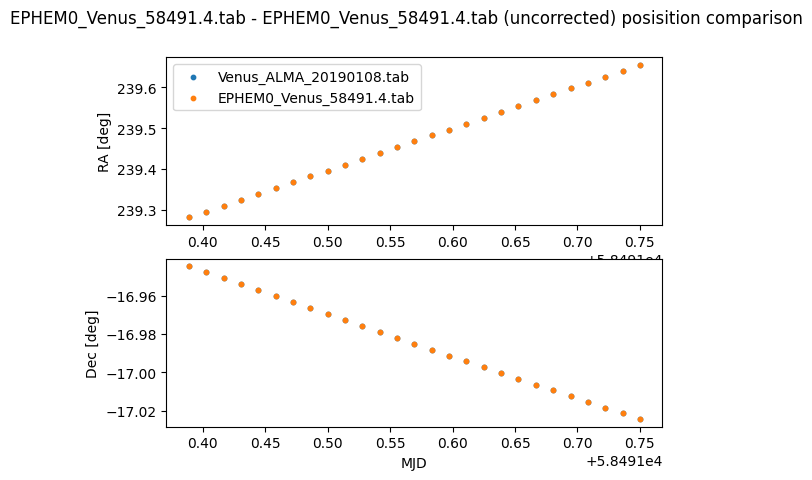

diff RA min: -4.166666684568554e-06, max: 4.1666667129902635e-06, median: -8.333332743859501e-07
diff Dec min: -4.72222222569485e-06, max: 4.7222222185894225e-06, median: -5.555555482317232e-07


In [9]:
compare_ephemtable('Venus_ALMA_20190108.tab', inephemtab)

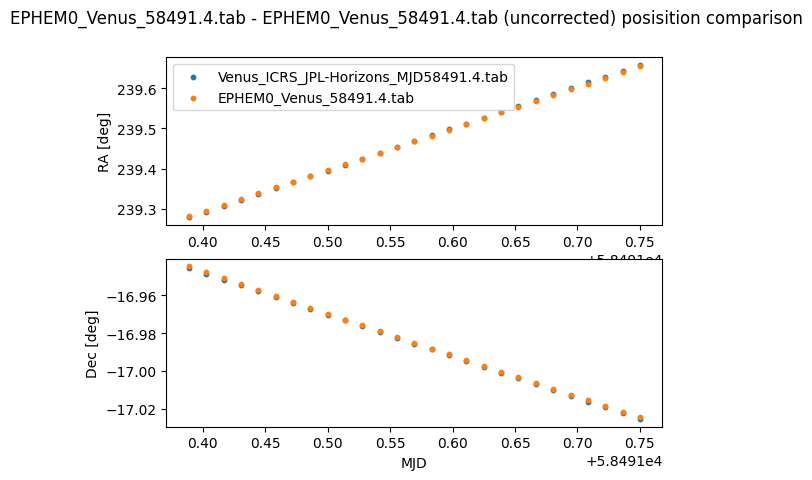

diff RA min: -0.002942499999960546, max: 0.0031958333333363953, median: 0.0003125000000068212
diff Dec min: -0.000993888888885408, max: -0.0003569444444444514, median: -0.0005291666666700223


In [10]:
extephtab = 'Venus_ICRS_JPL-Horizons_MJD58491.4.tab'
compare_ephemtable(extephtab, inephemtab)

In [33]:
# open topo ephem table 
tb.open('Venus_ALMA_20190108.tab')
inra0 = tb.getcol('RA')[0]
indec0 = tb.getcol('DEC')[0]
intm0 = tb.getcol('MJD')[0]
tb.done()
print(inra0,indec0)
print('t=',intm0)
# form direction measure
# its in ICRS based coord but centered on ALMA
#mdir = me.direction('ICRS', qa.quantity(inra0,'deg'), qa.quantity(indec0,'deg'))
mdir = me.direction('TOPO', qa.quantity(inra0,'deg'), qa.quantity(indec0,'deg'))

print(mdir)

239.2811 -16.9446
t= 58491.38888888889
{'m0': {'unit': 'rad', 'value': -2.106942274385783}, 'm1': {'unit': 'rad', 'value': -0.2957390604334312}, 'refer': 'TOPO', 'type': 'direction'}


In [34]:
def mdirInDeg(mdir):
    rad = qa.convert(mdir['m0'], 'deg')
    decd = qa.convert(mdir['m1'], 'deg')
    return (rad, decd)

In [36]:
me.doframe(me.epoch('utc',qa.quantity(intm0,'d')))
me.doframe(me.observatory('ALMA'))
azelgeodir = me.measure(mdir,'AZELGEO')
#print(mdirInDeg(azelgeodir))
icrsdir = me.measure(azelgeodir, 'ICRS')
#icrsdir = me.measure(mdir, 'ICRS')

print('t=', intm0)
print('icrsdir converted from the topo ephem tab: ', mdirInDeg(icrsdir))
print('attached eph dir:', mdirInDeg(mdir))

t= 58491.38888888889
icrsdir converted from the topo ephem tab:  ({'unit': 'deg', 'value': -120.98225088857497}, {'unit': 'deg', 'value': -16.892794143693447})
attached eph dir: ({'unit': 'deg', 'value': -120.71890000000002}, {'unit': 'deg', 'value': -16.9446})


In [37]:
# compare with the table in geocentric created by getephemtable 
tb.open('Venus_JPL-Horizons_MJD58491.4.tab')
inra1 = tb.getcol('RA')[0]
indec1 = tb.getcol('DEC')[0]
intm1 = tb.getcol('MJD')[0]
tb.done()
dir1 = me.direction('ICRS',qa.quantity(inra1,'deg'), qa.quantity(indec1,'deg'))
print('t=',intm1)
print('from geocentric table : ', mdirInDeg(dir1))

t= 58491.38888888889
from geocentric table :  ({'unit': 'deg', 'value': -120.72184}, {'unit': 'deg', 'value': -16.94543})


### Use convrttopoephem2geo to convert the ephem table in TOPO to geocentric

In [114]:
conveph.converttopoephem2geo('Venus_ALMA_20190108.tab','Venus_conveph_geo.tab')

True

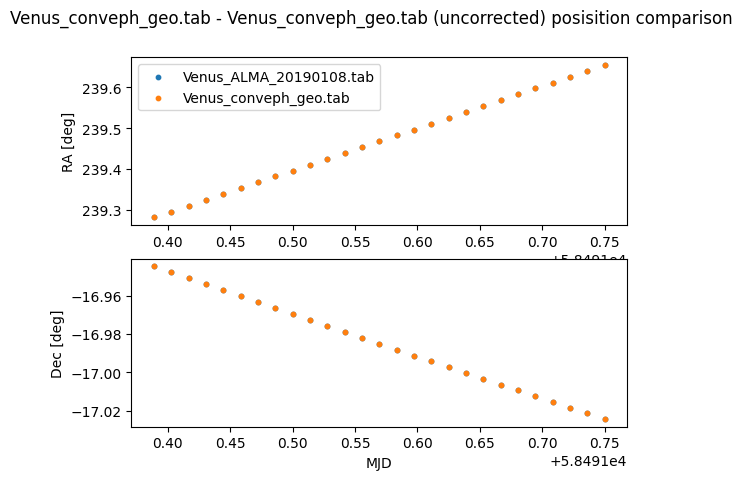

diff RA min: -2.842170943040401e-14, max: 5.684341886080802e-14, median: 2.842170943040401e-14
diff Dec min: 0.0, max: 3.552713678800501e-15, median: 0.0


In [117]:
compare_ephemtable('Venus_ALMA_20190108.tab', 'Venus_conveph_geo.tab')